In [1]:
from os import path
import re

from astropy.io import fits
import h5py
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from qso import lamost
from qso.utils import WAVEMIN, WAVEMAX

In [2]:
LAMOST_DIR = path.join("data", "lamost")
LAMOST_DR5 = path.join(LAMOST_DIR, "lamost_dr5_v3")
LAMOST_CATALOG = path.join(LAMOST_DIR, "dr5_v3.fits")
LAMOST_COVERAGE = path.join(LAMOST_DIR, "lamost_dr5_v3_coverage.csv")
LAMOST_QSO_CATALOG = path.join(LAMOST_DIR, "dr4dr5_qso_massflagged_v04.fits")

# LAMOST DR5 General Catalog

In [3]:
catalog_hdul = fits.open(LAMOST_CATALOG)
catalog_hdul.info()

catalog = catalog_hdul[1].data

Filename: data/lamost/dr5_v3.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      17   ()      
  1                1 BinTableHDU    130   9026365R x 37C   [J, 19A, 10A, J, J, 40A, B, B, D, D, E, E, E, E, E, 16A, 20A, 20A, E, E, 25A, E, E, E, E, E, E, E, 16A, 10A, 60A, 60A, B, E, D, D, I]   


In [4]:
catalog["lmjd"].dtype, catalog["planid"].dtype, catalog["spid"].dtype, catalog["fiberid"].dtype

(dtype('>i4'), dtype('<U40'), dtype('uint8'), dtype('uint8'))

In [5]:
np.all(catalog["lmjd"] - 1 == catalog["mjd"])

True

In [6]:
catalog_df = pd.read_csv(
    LAMOST_COVERAGE,
    index_col=["planid", "lmjd", "spid", "fiberid"],
    dtype={"wavemax": "f4", "wavemin": "f4"}
).sort_index()
catalog_df.info()
catalog_df.head()

/data/podondra/qso/venv/lib/python3.5/site-packages/numpy/lib/arraysetops.py:568: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


<class 'pandas.core.frame.DataFrame'>
MultiIndex: 9026365 entries, (B5591606, 55916, 1, 1) to (kepler08F56096, 56096, 16, 250)
Data columns (total 2 columns):
wavemax    float32
wavemin    float32
dtypes: float32(2)
memory usage: 129.2+ MB


wavemax      wavemin
planid   lmjd  spid fiberid                          
B5591606 55916 1    1        9099.134766  3699.986328
                    2        9099.134766  3699.986328
                    3        9099.134766  3699.986328
                    4        9099.134766  3699.986328
                    5        9099.134766  3699.986328

## Analysis

(3839.7244, 3.5843)

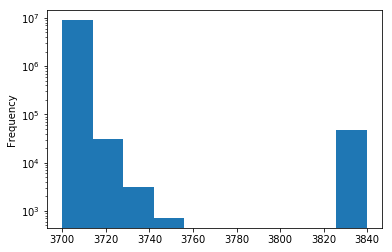

In [7]:
catalog_df["wavemin"].plot.hist(log=True)
wavemin = catalog_df["wavemin"].max()
wavemin, np.log10(wavemin)

(8914.597, 3.9501016)

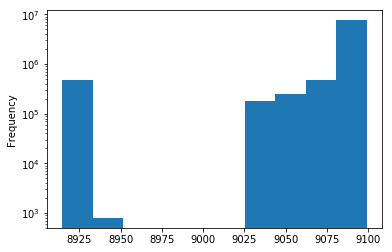

In [8]:
catalog_df["wavemax"].plot.hist(log=True)
wavemax = catalog_df["wavemax"].min()
wavemax, np.log10(wavemax)

In [9]:
random_spec = catalog_df.sample().index[0]
filepath = path.join(LAMOST_DR5, lamost.get_dr_path(*random_spec))

with fits.open(filepath) as hdul:
    header = hdul[0].header
    data = hdul[0].data
    lam = data[2]
    loglam = np.log10(lam)

lam, loglam

(array([3699.9863, 3700.8384, 3701.6907, ..., 9094.945 , 9097.04  ,
        9099.135 ], dtype=float32),
 array([3.5682   , 3.5683002, 3.5684001, ..., 3.9588   , 3.9589002,
        3.959    ], dtype=float32))

In [10]:
np.diff(loglam)

array([1.0013580e-04, 9.9897385e-05, 9.9897385e-05, ..., 9.9897385e-05,
       1.0013580e-04, 9.9897385e-05], dtype=float32)

In [11]:
EPS = 0.00005
loglam[(WAVEMIN - EPS <= loglam) & (loglam <= WAVEMAX + EPS)]

array([3.5843   , 3.5844002, 3.5845   , ..., 3.9499002, 3.95     ,
       3.9501002], dtype=float32)

# LAMOST DR4 & DR5 Quasar Catalog

In [12]:
qso_hdul = fits.open(LAMOST_QSO_CATALOG)
qso_hdul.info()

qso_catalog = qso_hdul[1].data

Filename: data/lamost/dr4dr5_qso_massflagged_v04.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      16   (5576,)   uint8   
  1  /Users/yaosu/acadOSciChina/major/data_and_resul/lamost/dr4dr5_par...    1 BinTableHDU    216   19253R x 102C   [J, 10A, 19A, D, D, J, 18A, I, I, D, I, 4A, D, I, D, I, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, E, D, I, D, D, D, D, D, D, D, D, D, D, D, D, D, E, D, I, D, D, D, D, D, D, D, D, D, D, D, D, D, E, D, I, D, D, D, D, D, D, D, D, D, D, D, D, E, D, I, D, D, D, D, D, D, D, D, D, 18A, 21A, D, D, D, D, 21A, D, D, D, D, D]   


In [13]:
qso_catalog["planid"].dtype, qso_catalog["lmjd"].dtype, qso_catalog["spid"].dtype, qso_catalog["fiberid"].dtype

(dtype('<U18'), dtype('>i4'), dtype('>i2'), dtype('>i2'))

In [14]:
qso_multiindex = pd.MultiIndex.from_arrays(
    [
        qso_catalog["planid"],
        qso_catalog["lmjd"].astype("i4"),
        qso_catalog["spid"].astype("i2"),
        qso_catalog["fiberid"].astype("i2"),
    ],
    names=["planid", "lmjd", "spid", "fiberid"]
)

qso_missing = qso_multiindex.difference(catalog_df.index)

qso_multiindex = qso_multiindex.difference(qso_missing)
qso_multiindex.shape

(18831,)

In [15]:
qso_missing.shape

(422,)

In [16]:
catalog_df["qso"] = False
catalog_df.loc[qso_multiindex, "qso"] = True
catalog_df

wavemax      wavemin    qso
planid         lmjd  spid fiberid                                 
B5591606       55916 1    1        9099.134766  3699.986328  False
                          2        9099.134766  3699.986328  False
                          3        9099.134766  3699.986328  False
                          4        9099.134766  3699.986328  False
                          5        9099.134766  3699.986328  False
...                                        ...          ...    ...
kepler08F56096 56096 16   246      9099.134766  3699.986328  False
                          247      9099.134766  3699.986328  False
                          248      9099.134766  3699.986328  False
                          249      9099.134766  3699.986328  False
                          250      9099.134766  3699.986328  False

[9026365 rows x 3 columns]

Filename: data/lamost/lamost_dr5_v3/20160313/HD131318N132328M01/spec-57461-HD131318N132328M01_sp03-118.fits.gz
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  Flux          1 PrimaryHDU     127   (3909, 5)   float32   


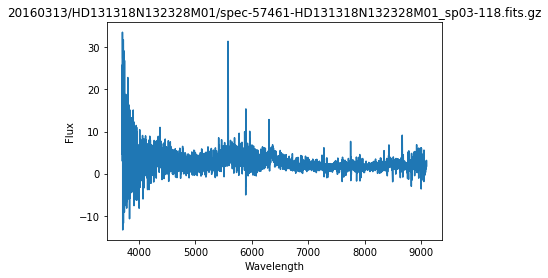

In [17]:
def plot_spec(planid, lmjd, spid, fiberid):
    dr_path = lamost.get_dr_path(planid, lmjd, spid, fiberid)
    filepath = path.join(LAMOST_DR5, dr_path)
    
    with fits.open(filepath) as hdul:
        hdul.info()
        data = hdul[0].data
        ax = plt.axes(xlabel="Wavelength", ylabel="Flux", title=dr_path)
        ax.plot(data[2], data[0])


qso = catalog_df[catalog_df["qso"]].sample()
planid, lmjd, spid, fiberid = qso.index[0]
plot_spec(planid, lmjd, spid, fiberid)